# Audio tagging on UrbanSound8K
## Introduction
This notebook demonstrates audio tagging (also known as sound event classification) using Python/Pytorch. Audio tagging is a technique for identifying the types of sound events that a given audio file contains. For instance, given audio files containing sound events such as a car horn or a dog bark, the goal is to accurately identify them as “car” or “dog”. For simplicity, here we focus on the monophonic case where each audio file is presumed to contain only a single type of sound event. In this case, the problem can be cast as a classification problem, which aims to predict the class of the sound event that a given audio file contains.

A prevalent approach to audio tagging uses a deep neural network (DNN), where its input and output are an audio file and prediction on the class label indicating the type of the sound event it contains, respectively. In this approach, the DNN is trained using data comprising input&ndash;output pairs, i.e., audio files annotated with class labels (also known as supervision). Such data are called labelled or supervised data. These data are used to compute a cost function such as the cross-entropy, which quantifies how far the DNN's prediction is from the true class indicated by the label. The DNN is trained so as to minimise the cost function using an optimiser such as the stochastic gradient descent or its variants. Such a training strategy using supervised data is called supervised learning.

In this notebook, we use the [UrbanSound8K](https://urbansounddataset.weebly.com/urbansound8k.html) dataset. This dataset contains 8,732 labeled sound clips (<=4s) from 10 classes: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, and street_music. 

## Import libraries and define constants
First, we import necessary libraries and define constants.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
import pandas as pd
import IPython
from IPython.display import Audio
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

num_classes = 10   # Number of classes
resample_rate = 16000   # Sampling rate (Hz) after resampling
wave_len = 32000   # Length of the input waveform after trancation (in samples)
frame_len = 1024   # Frame length (in samples)
hop = frame_len // 4
batch_size = 64   # Batch size
num_epochs = 10   # Number of epochs
compress_power = 1/3   # Exponent for power compression of the input spectrogram
learning_rate = 0.001   # Learning rate

## Prepare data
The following code downloads the UrbanSound8K dataset and untar it (this may take a few minutes):

In [2]:
%%capture
!wget https://goo.gl/8hY5ER
!tar -xvf 8hY5ER -C ./

The dataset consists of audio data and metadata, including class IDs. The audio data are located in `UrbanSound8K/audio`. The metadata are in `UrbanSound8K/metadata/UrbanSound8K.csv`, where each line of this csv file shows metadata for each sound clip, including the file name and the class label. The class labels are defined as follows: air_conditioner (0), car_horn (1), children_playing (2), dog_bark (3), drilling (4), engine_idling (5), gun_shot (6), jackhammer (7), siren (8), and street_music (9).


In [3]:
data_dir = 'UrbanSound8K/audio'
metadata_file = 'UrbanSound8K/metadata/UrbanSound8K.csv'
metadata = pd.read_csv(metadata_file, usecols=['slice_file_name', 'fold', 'classID', 'class'])
metadata.head()

,slice_file_name,fold,classID,class
0,100032-3-0-0.wav,5,3,dog_bark
1,100263-2-0-117.wav,5,2,children_playing
2,100263-2-0-121.wav,5,2,children_playing
3,100263-2-0-126.wav,5,2,children_playing
4,100263-2-0-137.wav,5,2,children_playing


Here is an audio example and the corresponding class label:

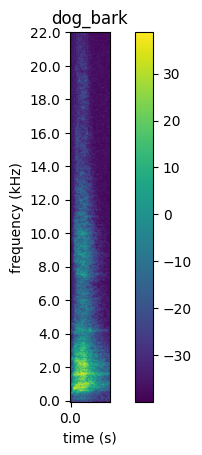

In [4]:
def show_example(idx):
    file_path = os.path.join(data_dir, 'fold' + str(metadata['fold'][idx]), str(metadata['slice_file_name'][idx]))
    waveform, sampling_rate = torchaudio.load(file_path)
    label = metadata['class'][idx]
    spec = torch.stft(input = waveform,
                      n_fft = frame_len,
                      hop_length = hop,
                      window = torch.hamming_window(frame_len),
                      return_complex = True)
    plt.imshow(20 * np.log10(np.abs(np.flipud(spec[0])) + 10**-2))
    plt.title(label)
    plt.colorbar()
    plt.xlabel('time (s)')
    plt.ylabel('frequency (kHz)')
    plt.xticks(np.arange(0.0, spec.size(2), sampling_rate / hop * 0.5), np.arange(0.0, spec.size(2) / sampling_rate * hop, 0.5))
    plt.yticks(np.arange(0, frame_len / 2 + 10**-4, frame_len / sampling_rate * 1000 * 2), np.arange(np.floor(sampling_rate / 1000 / 2.0), -10**-4, -2))   # Bug?
    plt.show()
    IPython.display.display(Audio(waveform, rate=sampling_rate))

show_example(0)

Here is another example:

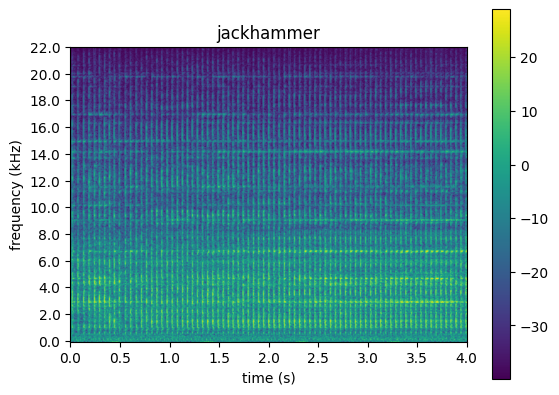

In [5]:
show_example(400)

Let us prepare the dataloader:

In [6]:
class UrbanSound8K(Dataset):
    def __init__(self, data_dir, metadata_file, resample_rate):
        self.data_dir = data_dir
        self.metadata = pd.read_csv(metadata_file)
        self.resample_rate = resample_rate

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):

        # Load audio data and label information
        file_path = os.path.join(self.data_dir, 'fold' + str(self.metadata['fold'][idx]), str(self.metadata['slice_file_name'][idx]))
        waveform, original_sample_rate = torchaudio.load(file_path)
        waveform = waveform[0]
        waveform = (waveform - torch.mean(waveform)) / torch.std(waveform)
        label = self.metadata['classID'][idx]

        # Resample the input waveform to ensure all input waveforms share the same sampling rate (self.resample_rate)
        waveform = torchaudio.transforms.Resample(original_sample_rate, self.resample_rate)(waveform)

        # Trancate/zero-pad the input waveform to ensure all input waveforms share the same length (wave_len)
        if waveform.size(0) < wave_len:
            waveform = torch.cat([waveform, torch.zeros(wave_len - waveform.size(0))], dim = 0)
        else:
            waveform = waveform[:wave_len]

        # Apply the short-time Fourier transform (STFT) to the input waveform
        feat = torch.stft(input = waveform,
                          n_fft = frame_len,
                          hop_length = hop,
                          window = torch.hamming_window(frame_len),
                          return_complex = True)

        # Compute the magnitude spectrogram and apply power compression to it
        feat = torch.abs(feat) ** compress_power

        return feat[None, :, :], label, waveform

# Instantiate the dataset
dataset = UrbanSound8K(data_dir, metadata_file, resample_rate)

# Split the dataset into train and test data
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=0)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Define the model, loss, and optimiser
Now we define the model, the loss, and the optimiser:

In [7]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, 3, padding='same')
        self.pool = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(4, 8, 3, padding='same')
        self.fc1 = nn.Linear(128 * 31 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 128 * 31 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Train and evaluate the model
The following code performs training and evaluation:

In [8]:
# Training
for epoch in range(num_epochs):
    model.train()
    running_loss = torch.Tensor([0.]).to(device)
    for data, labels, _ in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
        data = data.to(device, non_blocking = True)
        labels = labels.to(device, non_blocking = True)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Training Loss: {running_loss.item() / len(train_loader):.5f}')

# Evaluation
model.eval()
correct, total = torch.Tensor([0.]).to(device), torch.Tensor([0.]).to(device)

with torch.no_grad():
    for data, labels, _ in tqdm(test_loader, desc='Testing', leave=False):
        data = data.to(device, non_blocking = True)
        labels = labels.to(device, non_blocking = True)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy.item() * 100:.2f}%')

Training Loss: 1.57448


Training Loss: 0.84884


Training Loss: 0.52510


Training Loss: 0.28292


Training Loss: 0.14546


Training Loss: 0.06836


Training Loss: 0.04300


Training Loss: 0.01619


Training Loss: 0.01051


Training Loss: 0.02450


Test Accuracy: 75.27%


Here is an example prediction result:

In [9]:
class_list = ['air_conditioner', 'car_horn', 'children_playing',
              'dog_bark', 'drilling', 'engine_idling',
              'gun_shot', 'jackhammer', 'siren', 'street_music']

def show_example_testset(idx):
    feat, true_label, waveform = test_dataset[idx]
    spec = feat ** (1 / compress_power)
    plt.imshow(20 * np.log10(np.abs(np.flipud(spec[0])) + 10**-2))
    plt.title(class_list[true_label])
    plt.colorbar()
    plt.xlabel('time (s)')
    plt.ylabel('frequency (kHz)')
    plt.xticks(np.arange(0.0, spec.size(2), 31.25), np.arange(0.0, spec.size(2)*0.5/31.25, 0.5))
    plt.yticks(np.arange(0, 513, 128), np.arange(8, -10**-4, -2))
    plt.show()
    IPython.display.display(Audio(waveform, rate=resample_rate))
    _, est_label = torch.max(model(feat.to(device)).data, 1)
    print('estimated class:', class_list[est_label])

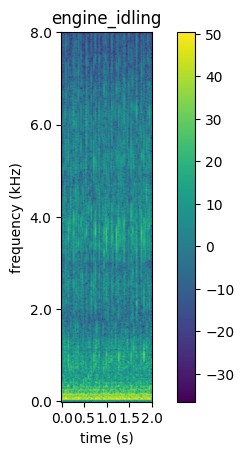

estimated class: engine_idling


In [10]:
show_example_testset(0)

Here is another example:

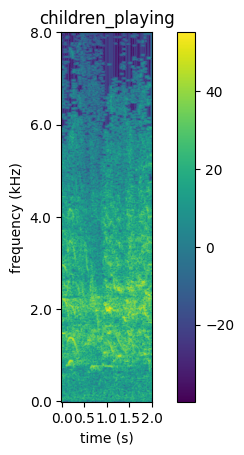

estimated class: children_playing


In [11]:
show_example_testset(150)